In [26]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
internal_train_data = pd.read_csv("data/3_internal_train_data.csv")
internal_validation_data = pd.read_csv("data/3_internal_validation_data.csv")

In [3]:
internal_train_data['Date'] = pd.to_datetime(internal_train_data['Date'])
internal_validation_data['Date'] = pd.to_datetime(internal_validation_data['Date'])

In [4]:
internal_train_data.head(10)

,Date,Total_FTE
0,2020-02-01,278
1,2020-03-01,306
2,2020-04-01,337
3,2020-05-01,477
4,2020-06-01,600
5,2020-07-01,658
6,2020-08-01,847
7,2020-09-01,988
8,2020-10-01,1091
9,2020-11-01,1239


In [5]:
internal_validation_data.head(10)

,Date,Total_FTE
0,2023-10-01,4799
1,2023-11-01,4853
2,2023-12-01,4855
3,2024-01-01,4804
4,2024-02-01,4944
5,2024-03-01,4611
6,2024-04-01,4535
7,2024-05-01,4691
8,2024-06-01,4661
9,2024-07-01,4936


# Arima

In [6]:
from statsmodels.tsa.arima.model import ARIMA

In [11]:
train_series = internal_train_data.set_index('Date')['Total_FTE']
val_series = internal_validation_data.set_index('Date')['Total_FTE']

print(train_series.head(10))
print(val_series.head(10))

Date
2020-02-01     278
2020-03-01     306
2020-04-01     337
2020-05-01     477
2020-06-01     600
2020-07-01     658
2020-08-01     847
2020-09-01     988
2020-10-01    1091
2020-11-01    1239
Name: Total_FTE, dtype: int64
Date
2023-10-01    4799
2023-11-01    4853
2023-12-01    4855
2024-01-01    4804
2024-02-01    4944
2024-03-01    4611
2024-04-01    4535
2024-05-01    4691
2024-06-01    4661
2024-07-01    4936
Name: Total_FTE, dtype: int64


In [39]:
def compute_arima_monthly_rolling(
    internal_train_data: pd.DataFrame,
    internal_validation_data: pd.DataFrame,
    order: tuple,
    label_train: str = 'Train',
    label_val: str = 'Validation',
    save_rolling_validation_df: bool = False
) -> tuple[float, float, float]:
    
    train_data = internal_train_data.copy().reset_index(drop=True)
    val_data = internal_validation_data.copy().reset_index(drop=True)
    
    history = train_data['Total_FTE'].copy()
    predictions = []

    for i in range(len(val_data)):
        model = ARIMA(history, order=order)
        fitted_model = model.fit()

        forecast = fitted_model.forecast(steps=1).iloc[0]
        predictions.append(forecast)

        history = pd.concat(
            [history, pd.Series([val_data.loc[i, 'Total_FTE']])],
            ignore_index=True
        )

    predictions = pd.Series(predictions, index=val_data.index)
    
    if save_rolling_validation_df:
        rolling_validation_df = pd.concat([val_data['Date'], val_data['Total_FTE'], predictions], axis=1)
        rolling_validation_df.columns = ['Date', 'Actual', 'Predicted']
        rolling_validation_df.to_csv(f'data/rolling_{label_val}_df.csv', index=False)

    mae = mean_absolute_error(val_data['Total_FTE'], predictions)
    mse = mean_squared_error(val_data['Total_FTE'], predictions)
    rmse = np.sqrt(mse)

    print(f"ARIMA{order} Rolling Monthly Results:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")

    plt.plot(
        train_data['Date'],
        train_data['Total_FTE'],
        label=f'{label_train}',
        color='blue',
        alpha=0.7
    )
    plt.plot(
        val_data['Date'],
        val_data['Total_FTE'],
        label=f'{label_val}',
        color='green',
        alpha=0.7
    )
    plt.plot(
        val_data['Date'],
        predictions,
        label=f'ARIMA{order}',
        color='red',
        linestyle='--',
        alpha=0.7
    )
    plt.axvline(
        train_data['Date'].iloc[-1],
        color='gray',
        linestyle=':',
        linewidth=1,
        label=label_train + '/' + label_val + ' Split'
    )
    plt.xlabel('Date')
    plt.ylabel('Total FTE')
    plt.title(f'ARIMA{order} Rolling Monthly Forecast')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    results_row = {
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "model": "arima_monthly_rolling",
        "order_p": order[0],
        "order_d": order[1],
        "order_q": order[2],
        "label_train": label_train,
        "label_val": label_val,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
    }

    results_path = "results/validation_results.csv"
    results_df = pd.DataFrame([results_row])

    if os.path.exists(results_path):
        existing = pd.read_csv(results_path)
        duplicate_mask = (
            (existing.get("timestamp", "") == results_row["timestamp"]) &
            (existing.get("model", "") == results_row["model"]) &
            (existing.get("order_p", -1) == results_row["order_p"]) &
            (existing.get("order_d", -1) == results_row["order_d"]) &
            (existing.get("order_q", -1) == results_row["order_q"])
        )
        if not duplicate_mask.any():
            updated = pd.concat([existing, results_df], ignore_index=True)
            updated.to_csv(results_path, index=False)
    else:
        results_df.to_csv(results_path, index=False)

    return mae, mse, rmse

In [28]:
orders = [
    (0, 1, 0),  # Naïve
    (1, 1, 0),
    (0, 1, 1),
    (1, 1, 1)
]

ARIMA(0, 1, 0) Rolling Monthly Results:
MAE: 121.58
MSE: 26444.08
RMSE: 162.62


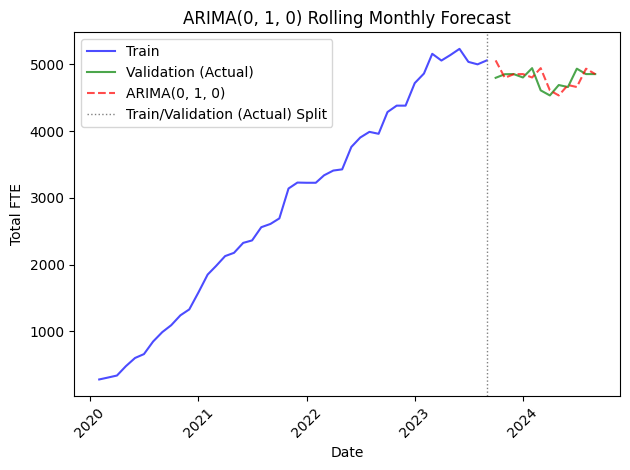

ARIMA(1, 1, 0) Rolling Monthly Results:
MAE: 152.81
MSE: 36262.46
RMSE: 190.43


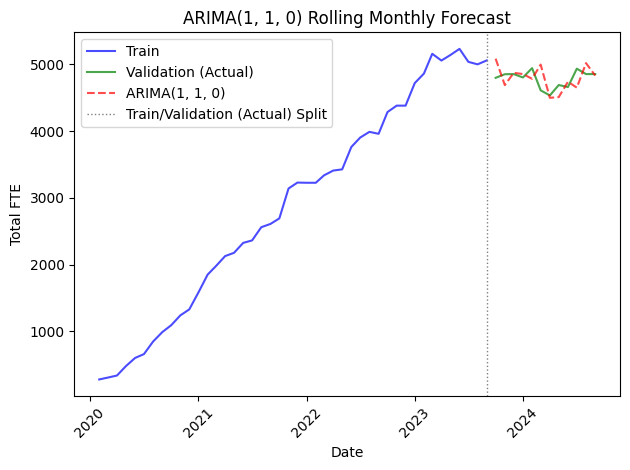

ARIMA(0, 1, 1) Rolling Monthly Results:
MAE: 143.01
MSE: 33143.48
RMSE: 182.05


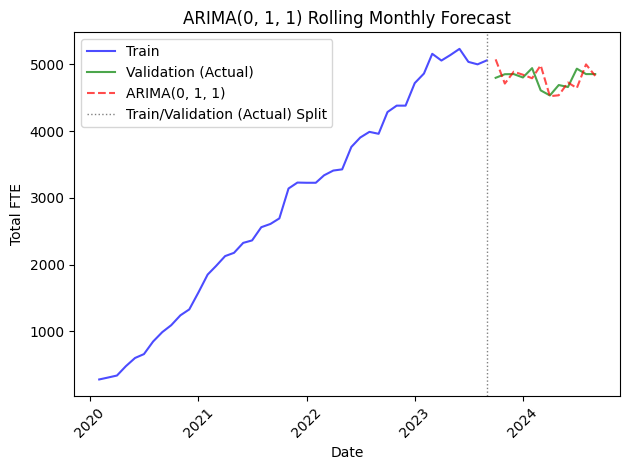

/home/jsforerobiomed/proyectos_academicos/sanofi/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsforerobiomed/proyectos_academicos/sanofi/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsforerobiomed/proyectos_academicos/sanofi/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jsforerobiomed/proyectos_academicos/sanofi/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-s

ARIMA(1, 1, 1) Rolling Monthly Results:
MAE: 137.19
MSE: 34499.93
RMSE: 185.74


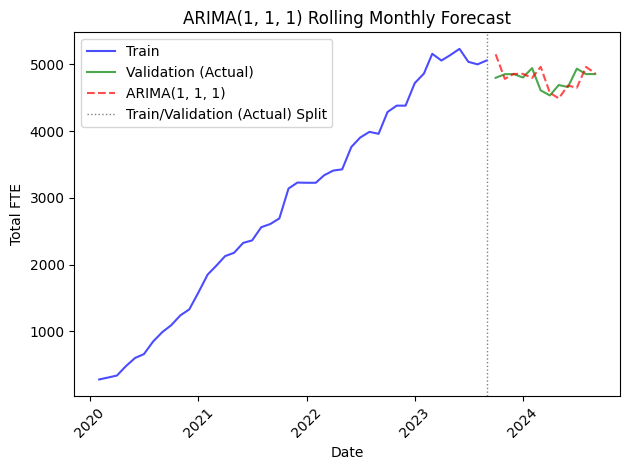

In [29]:

for order in orders:
    compute_arima_monthly_rolling(
        internal_train_data,
        internal_validation_data,
        order
    )

ARIMA(0, 1, 0) Rolling Monthly Results:
MAE: 121.58
MSE: 26444.08
RMSE: 162.62


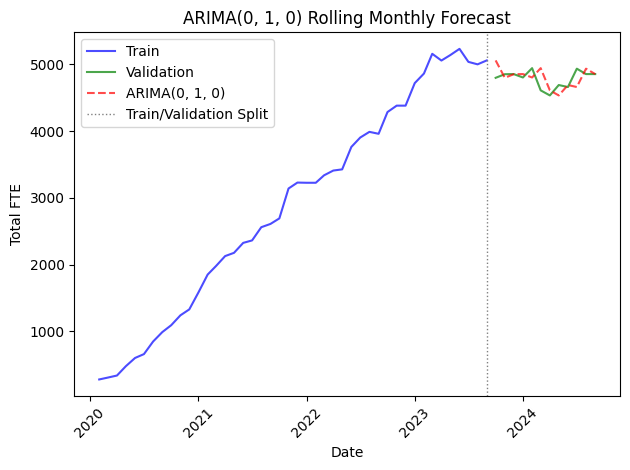

(121.58333333333333, 26444.083333333332, np.float64(162.6163685897989))

In [37]:
compute_arima_monthly_rolling(
    internal_train_data,
    internal_validation_data,
    (0, 1, 0),
    save_rolling_validation_df=True
)

In [30]:
def compute_arima_insample(
    train_data: pd.DataFrame,
    orders: list[tuple]
) -> pd.DataFrame:
    
    train = train_data.copy()
    train['Date'] = pd.to_datetime(train['Date'])
    train = train.sort_values('Date').reset_index(drop=True)

    y = train['Total_FTE']

    results = []

    for order in orders:
        model = ARIMA(y, order=order)
        fitted = model.fit()

        fitted_values = fitted.fittedvalues

        aligned = pd.concat([y, fitted_values], axis=1).dropna()
        aligned.columns = ['y_true', 'y_pred']

        mae = mean_absolute_error(aligned['y_true'], aligned['y_pred'])
        mse = mean_squared_error(aligned['y_true'], aligned['y_pred'])
        rmse = np.sqrt(mse)

        results.append({
            'timestamp': datetime.now().isoformat(timespec="seconds"),
            'model': f'ARIMA{order}',
            'order_p': order[0],
            'order_d': order[1],
            'order_q': order[2],
            'MAE_insample': mae,
            'MSE_insample': mse,
            'RMSE_insample': rmse,
            'n_obs_used': len(aligned)
        })

    results_df = pd.DataFrame(results)

    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)
    results_path = os.path.join(results_dir, "train_results.csv")

    if os.path.exists(results_path):
        existing = pd.read_csv(results_path)
        updated = pd.concat([existing, results_df], ignore_index=True)
        updated.to_csv(results_path, index=False)
    else:
        results_df.to_csv(results_path, index=False)

    return results_df

In [31]:
insample_results = compute_arima_insample(
    internal_train_data,
    orders
)

print(insample_results.sort_values('RMSE_insample'))

             timestamp           model  order_p  order_d  order_q  \
3  2026-01-06T11:08:42  ARIMA(1, 1, 1)        1        1        1   
1  2026-01-06T11:08:42  ARIMA(1, 1, 0)        1        1        0   
2  2026-01-06T11:08:42  ARIMA(0, 1, 1)        0        1        1   
0  2026-01-06T11:08:42  ARIMA(0, 1, 0)        0        1        0   

   MAE_insample  MSE_insample  RMSE_insample  n_obs_used  
3     97.479794  17100.349637     130.768305          44  
1    107.757558  22919.102770     151.390564          44  
2    113.545161  24650.277803     157.004069          44  
0    131.590909  28095.500000     167.617123          44  


/home/jsforerobiomed/proyectos_academicos/sanofi/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


# Test data

In [10]:
train_data = pd.concat([internal_train_data, internal_validation_data])

In [11]:
internal_train_data.head()

,Date,Total_FTE
0,2020-02-01,278
1,2020-03-01,306
2,2020-04-01,337
3,2020-05-01,477
4,2020-06-01,600


In [12]:
internal_validation_data.tail()

,Date,Total_FTE
7,2024-05-01,4691
8,2024-06-01,4661
9,2024-07-01,4936
10,2024-08-01,4855
11,2024-09-01,4855


In [13]:
train_data.head()

,Date,Total_FTE
0,2020-02-01,278
1,2020-03-01,306
2,2020-04-01,337
3,2020-05-01,477
4,2020-06-01,600


In [14]:
train_data.tail()

,Date,Total_FTE
7,2024-05-01,4691
8,2024-06-01,4661
9,2024-07-01,4936
10,2024-08-01,4855
11,2024-09-01,4855


In [15]:
test_data = pd.read_csv("data/.test/test_data.csv")

In [17]:
test_data['Date'] = pd.to_datetime(test_data['Date'])

ARIMA(0, 1, 0) Rolling Monthly Results:
MAE: 151.07
MSE: 37555.60
RMSE: 193.79


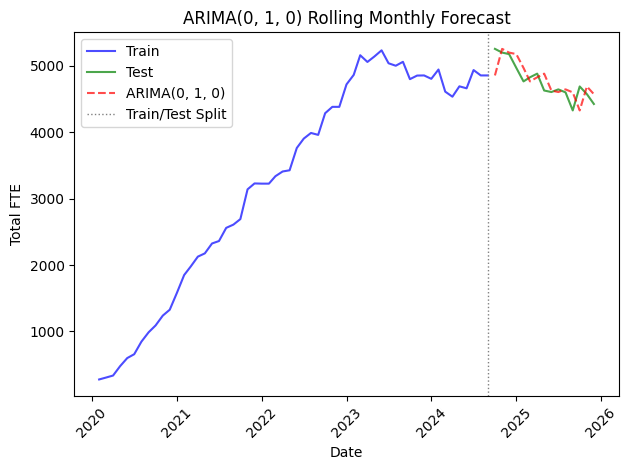

(151.06666666666666, 37555.6, np.float64(193.79267272010054))

In [38]:
compute_arima_monthly_rolling(
        train_data,
        test_data,
        (0, 1, 0),
        label_train='Train',
        label_val='Test',
        save_rolling_validation_df=True
    )